In [23]:
# Exploratory Data Analysis (IO-Bound)

# In this notebook I'll perform EDA to explain feature columns, 
# their relationships and overall everything we should know about the
# given dataset.

In [24]:
# Feature Columns

# time_ms = Timestamp of measurement in milliseconds

# cpu_psi_some_* = Shows how much time tasks are delayed because CPU is saturated. 

# cpu_psi_full_* = Percentage of time all non-idle tasks are stalled, waiting for CPU.  

# io_psi_some_* = Shows delay caused by storage / disk IO.

# io_psi_full_* = All runable tasks blocked on IO.

# mem_psi_some_* = Shows tasks waiting in memory.

# mem_psi_full_* = Shows all tasks stalled due to memory pressure.

# load_avg_* = Average number of runnable or IO-waiting tasks over time windows.

# procs_running = Number of processes currently runable.

# procs_blocked = Number of processes blocked waiting for IO completion.

# procs_disk_io = Processes specifically blocked on disk IO.

# Some -> At least 1 task waiting.
# Full -> Entire workload stalled.

In [25]:
# Imports

from pathlib import Path
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

In [26]:
# Read CSV files

PROJECT_ROOT = Path.cwd().parent.parent
DATASET_DIR = PROJECT_ROOT / "datasets"
PRIO_DIR = DATASET_DIR / "prio-io.csv"
RR_DIR = DATASET_DIR / "rr-io.csv"

# Read
df_prio = pd.read_csv(PRIO_DIR)
df_rr = pd.read_csv(RR_DIR)

# Normalize column names (strip whitespace) so they align across files
df_prio.columns = df_prio.columns.str.strip()
df_rr.columns = df_rr.columns.str.strip()

# df_prio.head(5)
# df_rr.head(5)

In [27]:
# Add scheduler label
df_prio["scheduler"] = "PRIORITY"
df_rr["scheduler"] = "RR"

# Add ID for both
df_prio["id"] = df_prio.index + 1
df_rr["id"] = df_rr.index + 1

In [28]:
# Combine
df = pd.concat([df_prio, df_rr], ignore_index=True)

In [29]:
# Small check-up

df.head(5)

,time_ms,cpu_psi_some_10,cpu_psi_some_60,cpu_psi_some_300,cpu_psi_full_10,cpu_psi_full_60,cpu_psi_full_300,io_psi_some_10,io_psi_some_60,io_psi_some_300,...,mem_psi_full_60,mem_psi_full_300,load_avg_1,load_avg_5,load_avg_15,procs_running,procs_blocked,procs_disk_io,scheduler,id
0,0,1.71,1.65,0.53,0,0,0,15.22,3.05,0.71,...,0,0,2.23,0.85,0.31,2,31,0,PRIORITY,1
1,1000,1.76,1.66,0.54,0,0,0,29.49,6.03,1.35,...,0,0,4.69,1.38,0.48,5,32,0,PRIORITY,2
2,2000,1.76,1.66,0.54,0,0,0,29.49,6.03,1.35,...,0,0,4.69,1.38,0.48,1,32,0,PRIORITY,3
3,3000,1.81,1.67,0.56,0,0,0,40.82,8.84,1.97,...,0,0,4.69,1.38,0.48,1,29,0,PRIORITY,4
4,4000,1.81,1.67,0.56,0,0,0,40.82,8.84,1.97,...,0,0,4.69,1.38,0.48,1,32,0,PRIORITY,5


In [30]:
# Drop columns that have no information

for col in [
    "cpu_psi_full_10",
    "cpu_psi_full_60",
    "cpu_psi_full_300",
    "mem_psi_some_10",
    "mem_psi_some_60",
    "mem_psi_some_300",
    "mem_psi_full_10",
    "mem_psi_full_60",
    "mem_psi_full_300"
    ]:
    
    df = df.drop(col, axis=1)

In [31]:
# Basic Cleaning

# Sort by scheduler + time
df = df.sort_values(["scheduler", "time_ms"])

# Check missing
print(df.isna().sum())

time_ms             0
cpu_psi_some_10     0
cpu_psi_some_60     0
cpu_psi_some_300    0
io_psi_some_10      0
io_psi_some_60      0
io_psi_some_300     0
io_psi_full_10      0
io_psi_full_60      0
io_psi_full_300     0
load_avg_1          0
load_avg_5          0
load_avg_15         0
procs_running       0
procs_blocked       0
procs_disk_io       0
scheduler           0
id                  0
dtype: int64


In [32]:
print(df["time_ms"])

0           0
1        1000
2        2000
3        3000
4        4000
        ...  
233    114000
234    115000
235    116000
236    117000
237    118000
Name: time_ms, Length: 238, dtype: int64


In [33]:
# Summary stats per scheduler

metrics = [c for c in df.columns if not c in ["time_ms", "scheduler", "id"]]

summary = df.groupby("scheduler")[metrics].agg([
    "mean",
    "std",
    "median",
    # TODO Add quantiles to summary
    "max"
])

print(summary)

          cpu_psi_some_10                        cpu_psi_some_60            \
                     mean       std median   max            mean       std   
scheduler                                                                    
PRIORITY         2.260252  0.183836   2.27  2.60        2.017731  0.179483   
RR               2.760756  0.195925   2.73  3.25        3.423613  0.369990   

                       cpu_psi_some_300            ... procs_running      \
          median   max             mean       std  ...        median max   
scheduler                                          ...                     
PRIORITY    2.05  2.27         0.854202  0.178954  ...           1.0  15   
RR          3.34  4.25         3.082689  0.042059  ...           2.0  23   

          procs_blocked                     procs_disk_io                  
                   mean      std median max          mean  std median max  
scheduler                                                                  


In [34]:
# TODO Spike / Stall Detection might be implemented if seen as necessary

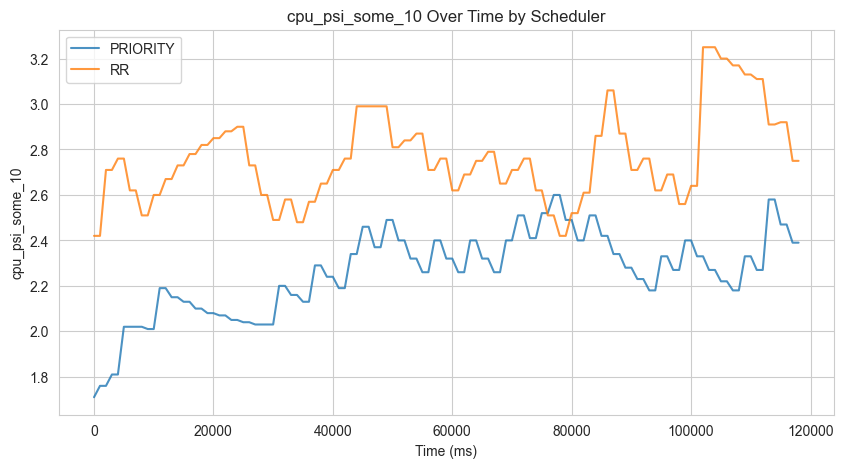

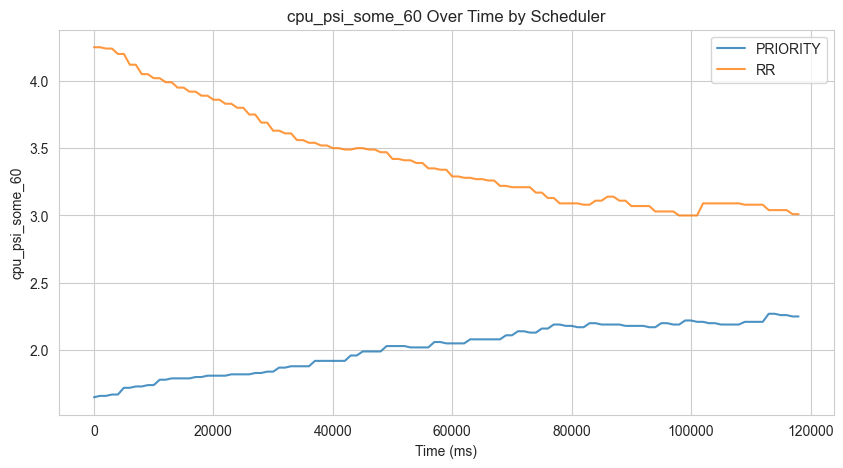

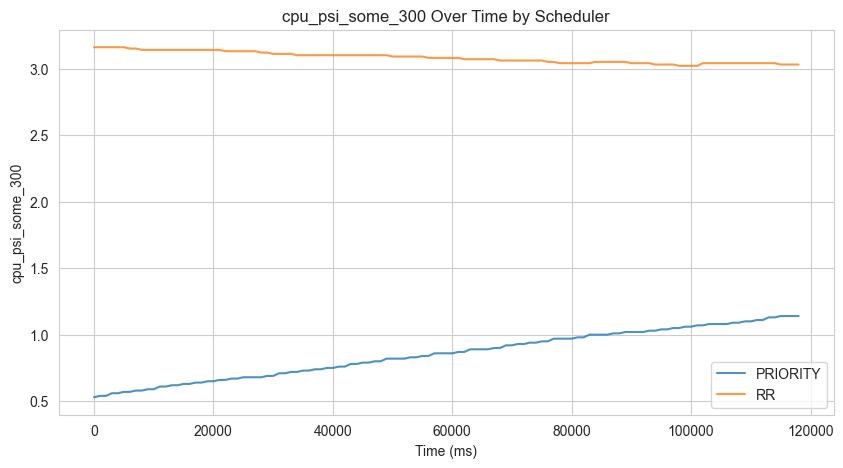

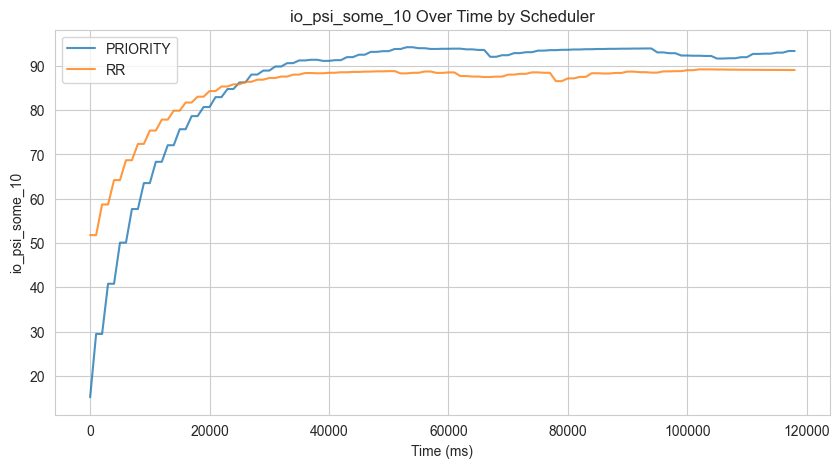

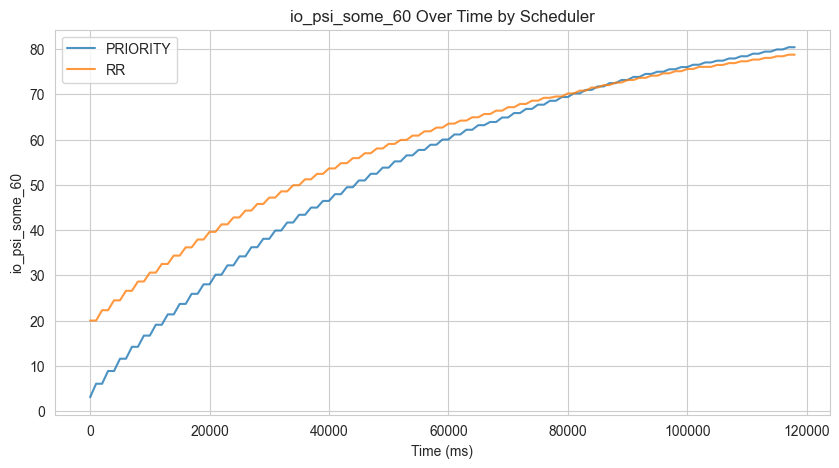

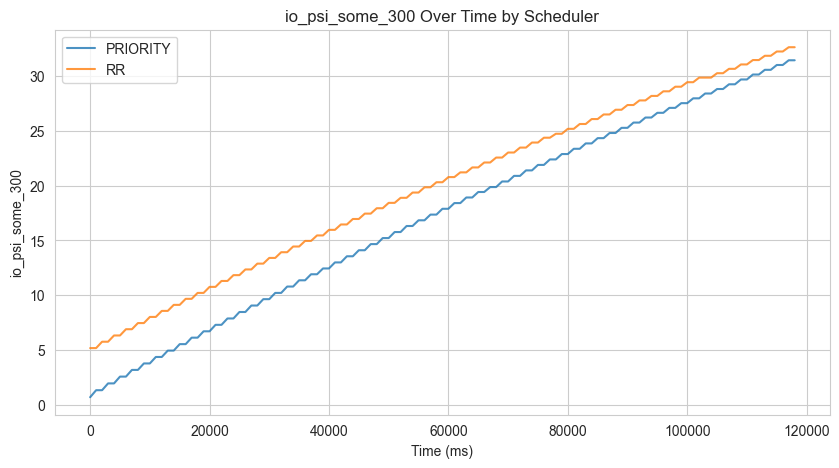

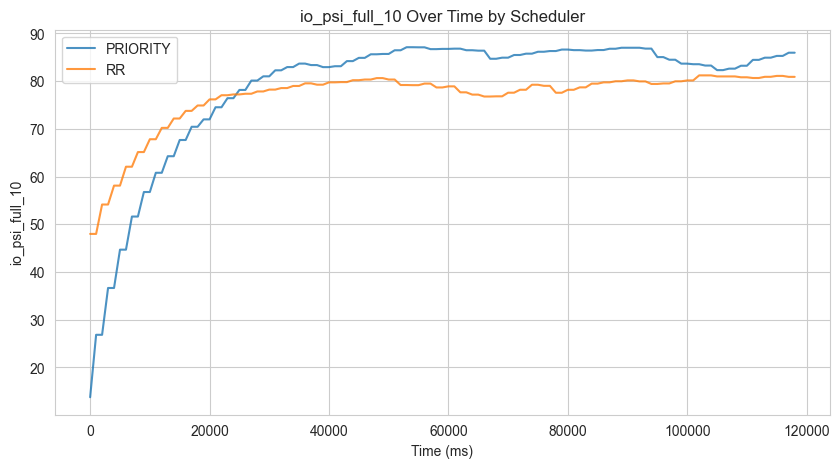

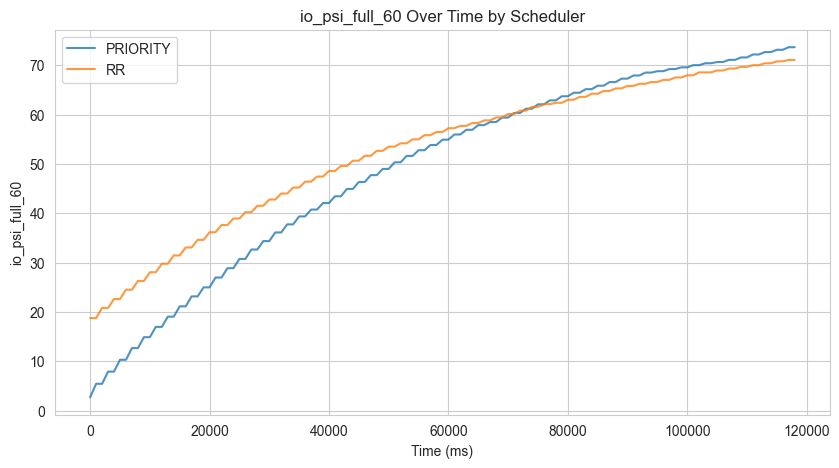

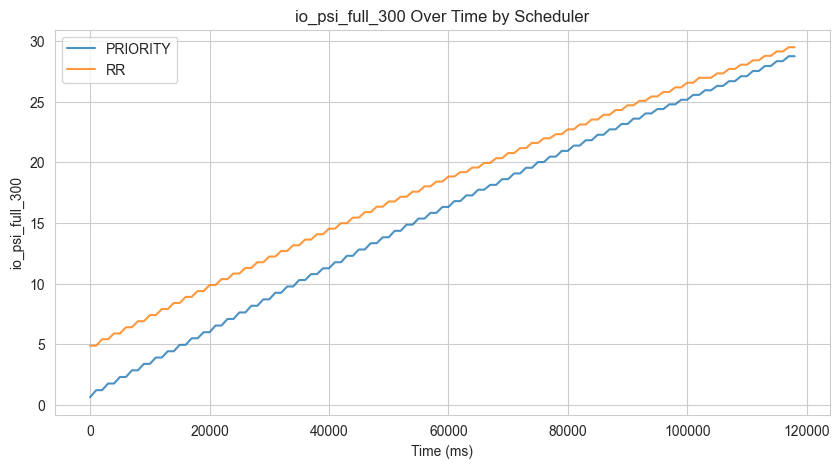

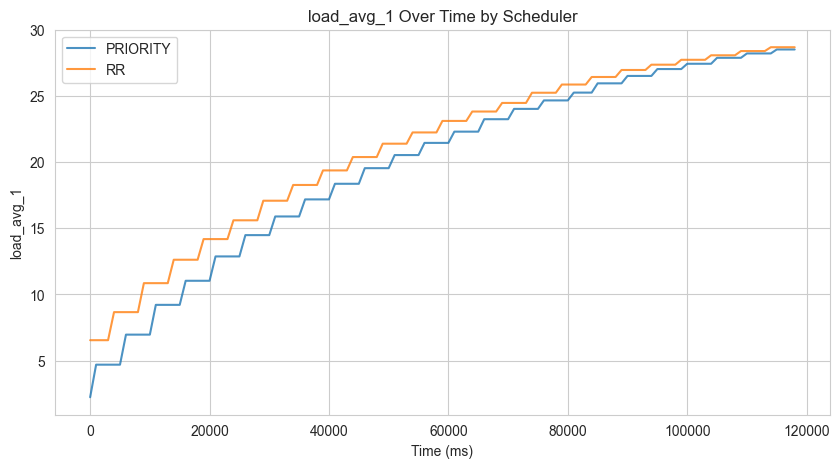

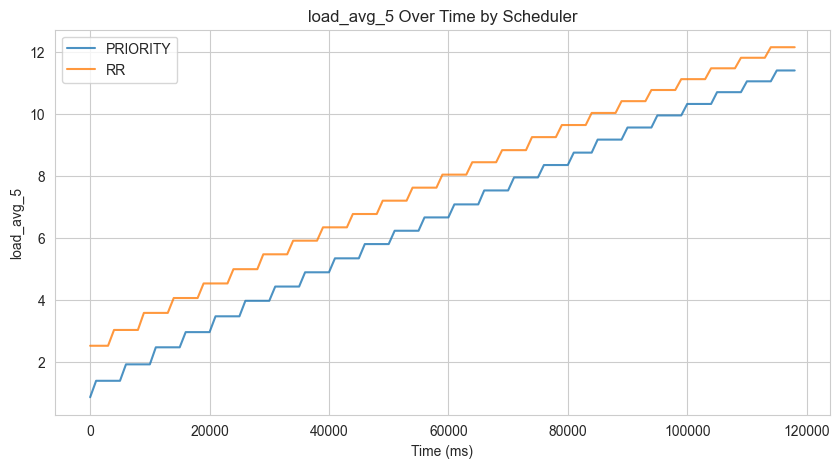

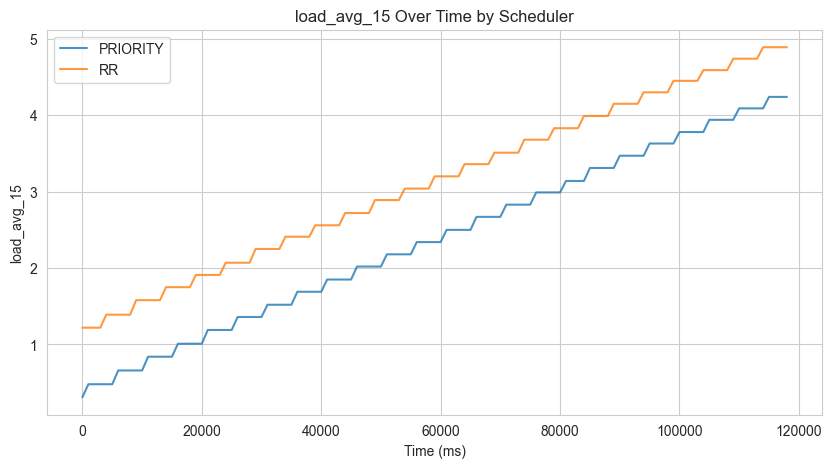

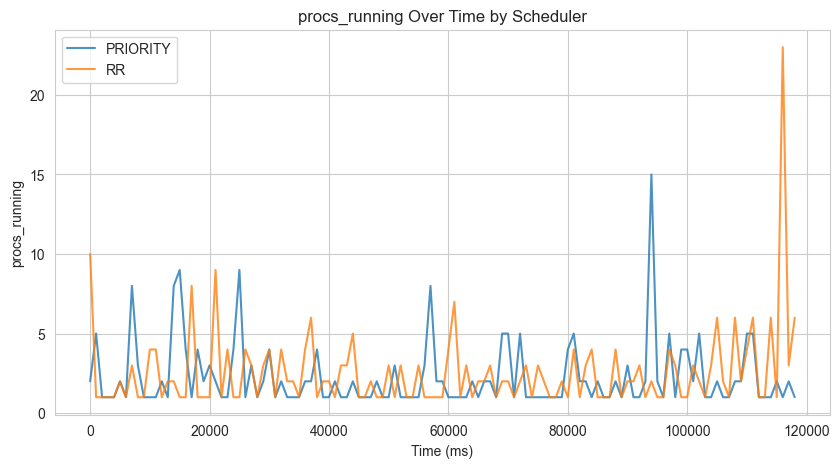

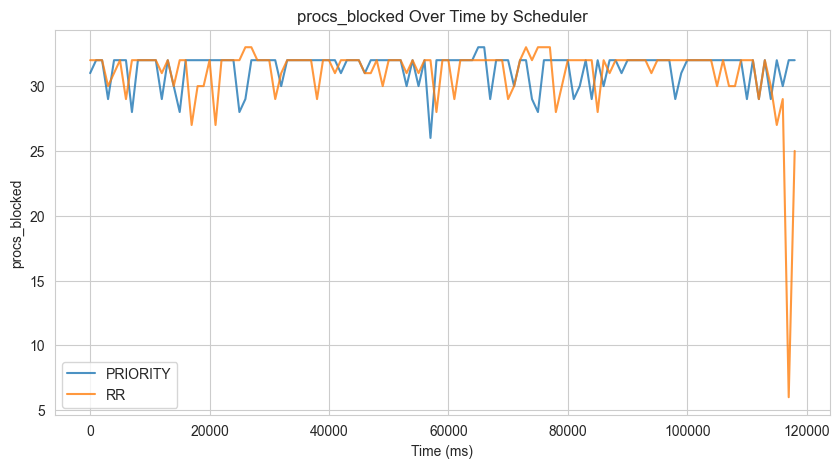

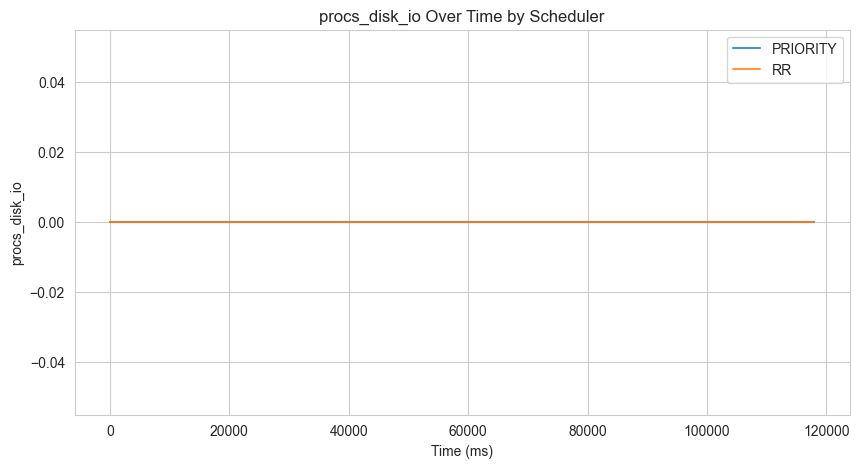

In [35]:
# Line graph of every metric with respect to time_ms

for col in metrics:
    plt.figure(figsize=(10,5))
    
    for sched in df["scheduler"].unique():
        sub = df[df["scheduler"] == sched]
        plt.plot(sub["time_ms"], sub[col], label=sched, alpha=0.8)
    
    plt.title(f"{col} Over Time by Scheduler")
    plt.xlabel("Time (ms)")
    plt.ylabel(col)
    plt.legend()
    plt.grid(True)
    plt.show()